In [96]:
import MDAnalysis as mda
import numpy as np
from MDAnalysis.analysis.msd import EinsteinMSD
import os
import numpy as np
import MDAnalysis as mda

dirs = [
    "12-0_test-d-3_lim_in-lmp/",
    "13-0_test-d-4_lim_in-lmp/",
    "14-0_test-d-5_lim_in-lmp/",
    "15-0_test-d-6_lim_in-lmp/",
    "16-0_test-d-7_lim_in-lmp/",
]

# path1 = '/raid/hwding/gpumd/gpumd_dynamic/test4/fix/fix-C/'
path1 =  '/raid/hwding/gpumd/gpumd_dynamic/test5/' + dirs[-2] 
print(path1)
file1 = path1 + "properties.xyz"


/raid/hwding/gpumd/gpumd_dynamic/test5/15-0_test-d-6_lim_in-lmp/


In [ ]:

def write_msd_xyz(infile="properties.xyz", outfile="msd.xyz", encoding="utf-8"):
    """
    读取扩展XYZ(properties.xyz)：
      a) 按每帧: 第1行n_atoms, 第2行comment, 接着n_atoms行原子数据；先统计并输出总帧数
      b) 对每个原子行：保留第1列symbol + 第13-15列(unwrapped_position) 作为新的 x y z
      c) 每帧写入：原来的前两行 + 提取后的原子行 到 msd.xyz（与输入文件同目录）
    """
    import os

    # 让输出文件位于与输入文件相同的文件夹
    outfile = os.path.join(os.path.dirname(os.path.abspath(infile)), outfile)

    # pass 1: count frames
    nframes = 0
    with open(infile, "r", encoding=encoding) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.strip()
            if not line:
                continue
            try:
                n = int(line)
            except ValueError as e:
                raise ValueError(f"Frame header (n_atoms) parse failed at frame {nframes+1}: {line}") from e
            _comment = f.readline()
            if not _comment:
                raise EOFError(f"Unexpected EOF after n_atoms line in frame {nframes+1}")
            for _ in range(n):
                atom_line = f.readline()
                if not atom_line:
                    raise EOFError(f"Unexpected EOF in atom lines of frame {nframes+1}")
            nframes += 1

    print(nframes)

    # pass 2: write msd.xyz
    with open(infile, "r", encoding=encoding) as fin, open(outfile, "w", encoding=encoding) as fout:
        for _ in range(nframes):
            n_line = fin.readline()
            while n_line and not n_line.strip():
                n_line = fin.readline()
            if not n_line:
                break
            n = int(n_line.strip())
            comment = fin.readline()
            fout.write(f"{n}\n")
            fout.write(comment if comment.endswith("\n") else comment + "\n")

            for _ in range(n):
                parts = fin.readline().split()
                if len(parts) < 15:
                    raise ValueError(f"Atom line has <15 columns, cannot read unwrapped_position: {' '.join(parts)}")
                sym = parts[0]
                x, y, z = parts[12], parts[13], parts[14]  # 1-based 13-15
                fout.write(f"{sym} {x} {y} {z}\n")

    return outfile

if __name__ == "__main__":
    write_msd_xyz(infile=file1, outfile="msd_OH.xyz")


In [84]:
import os
import numpy as np
import MDAnalysis as mda

def write_O_relative_to_COM_xyz(file2, out_name="com_O.xyz", selection="name O", fmt="{:.8f}"):


    """
    读取多帧XYZ(file2)，每帧计算所选O原子组的COM，并将每个O原子坐标平移到相对COM坐标系：
      - 输出XYZ每帧第1行：O原子数
      - 第2行：保持原文件该帧的comment/lattice行不变
      - 后续：O x y z（相对COM）

    Returns: (out_file, n_frames, nO)
    """
    # 1) 读入Universe并选择O
    u = mda.Universe(file2)
    agO = u.select_atoms(selection)
    nO = agO.n_atoms
    if nO == 0:
        raise ValueError(f"选择 '{selection}' 得到0个原子，请检查元素符号/字段（如 O vs OW）。")

    # 2) 预读每帧第二行(comment/lattice)并统计帧数（按原始xyz文本）
    comments = []
    with open(file2, "r") as f:
        while True:
            line1 = f.readline()
            if not line1:
                break
            try:
                n = int(line1.strip().split()[0])
            except Exception:
                raise ValueError(f"XYZ格式错误：无法解析原子数行：{line1!r}")
            comment = f.readline()
            if comment == "":
                raise ValueError("XYZ格式错误：缺少第二行comment/lattice行")
            comments.append(comment.rstrip("\n"))
            for _ in range(n):
                if f.readline() == "":
                    raise ValueError("XYZ格式错误：原子行不完整（提前EOF）")

    n_frames = len(comments)

    # 3) 输出文件路径（与输入同目录）
    out_file = os.path.join(os.path.dirname(file2), out_name)

    # 4) 逐帧写出：O相对COM坐标
    with open(out_file, "w") as out:
        for ts in u.trajectory:
            com = agO.center_of_mass()
            rel = agO.positions - com  # (nO, 3)

            out.write(f"{nO}\n")
            out.write(comments[ts.frame] + "\n")
            for x, y, z in rel:
                out.write(f"O {fmt.format(x)} {fmt.format(y)} {fmt.format(z)}\n")

    return out_file, n_frames, nO


file2 = path1 + "msd_OH.xyz"

out_file, n_frames, nO = write_O_relative_to_COM_xyz(file2=file2, out_name="com_O.xyz", selection="name O", fmt="{:.8f}")

In [97]:

file3 =  path1+ "com_O.xyz"
u = mda.Universe(file3)
ag = u.select_atoms("name O")
for ts in u.trajectory:
    z = ag.positions[0, 2]   # 每帧第一个O原子的z
    print(ts.frame, ts.time, z)

       

/tmp/ipykernel_1576357/1721523777.py:6: UserWarning: Reader has no dt information, set to 1.0 ps
  print(ts.frame, ts.time, z)


0 0.0 -35.313828
1 1.0 -34.983265
2 2.0 -35.473476
3 3.0 -35.483955
4 4.0 -35.709667
5 5.0 -34.760723
6 6.0 -35.90046
7 7.0 -35.842896
8 8.0 -35.906086
9 9.0 -35.70615
10 10.0 -35.631157
11 11.0 -35.913956
12 12.0 -35.661438
13 13.0 -35.549847
14 14.0 -36.025642
15 15.0 -36.084385
16 16.0 -36.02779
17 17.0 -35.964657
18 18.0 -35.779724
19 19.0 -35.654903
20 20.0 -35.72696
21 21.0 -36.11941
22 22.0 -35.867985
23 23.0 -35.743366
24 24.0 -36.29912
25 25.0 -35.814224
26 26.0 -35.83731
27 27.0 -35.825203
28 28.0 -36.1243
29 29.0 -35.896614
30 30.0 -36.047344
31 31.0 -36.231373
32 32.0 -35.89381
33 33.0 -35.908707
34 34.0 -35.829052
35 35.0 -35.908432
36 36.0 -36.418346
37 37.0 -35.94009
38 38.0 -35.350613
39 39.0 -35.90891
40 40.0 -36.255104
41 41.0 -35.960655
42 42.0 -35.61401
43 43.0 -35.927185
44 44.0 -35.4615
45 45.0 -35.72172
46 46.0 -35.294483
47 47.0 -35.215862
48 48.0 -35.963207
49 49.0 -36.199974
50 50.0 -35.72032
51 51.0 -36.042957
52 52.0 -35.854195
53 53.0 -36.05968
54 54.0 -35.

100%|██████████| 499/499 [00:00<00:00, 7473.22it/s]


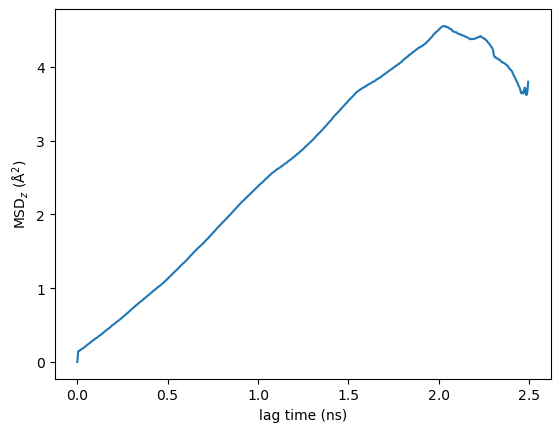

In [98]:
MSD_z = EinsteinMSD(ag, msd_type="z", fft=False)
MSD_z.run(start=500,stop=1000)   # 从第1500帧开始（0-based）
msd_z = MSD_z.results.timeseries   # 单位：Å^2
nframes = MSD_z.n_frames
import matplotlib.pyplot as plt
dt_fs = 5000
lag_ns = np.arange(nframes) * (dt_fs / 1000000.0)

plt.plot(lag_ns, msd_z)
plt.xlabel("lag time (ns)")
plt.ylabel("MSD$_z$ (Å$^2$)")
plt.show()

Dz = 9.38041e-08 cm^2/s
slope = 1.87608 Å^2/ns
Dz = 0.938041 Å^2/ns = 9.38041e-08 cm^2/s
r = 0.9660


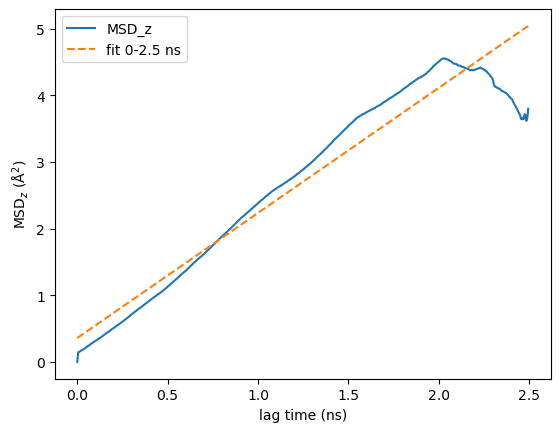

In [ ]:
from scipy.stats import linregress

# --- 线性拟合区间（单位：ps），按你的曲线线性段自行改 ---
t1_ns = 0
t2_ns = 2.5

i1 = int(t1_ns / (dt_fs / 1000000.0))
i2 = int(t2_ns / (dt_fs / 1000000.0))

fit = linregress(lag_ns[i1:i2], msd_z[i1:i2])
slope = fit.slope              # Å^2/ps

# 1D z方向：D = slope / (2*1)
d = 2.0 ## 根据公式，1D这里d=2
Dz_A2ps = slope / (2.0 *d)         # Å^2/ps

Dz_cm2s = Dz_A2ps * 1e-7  # cm^2/s（因为 1 Å^2/ns = 1e-7 cm^2/s）
print(f"Dz = {Dz_cm2s:.6g} cm^2/s")    # m^2/s（因为 1 Å^2/ps = 1e-8 m^2/s）

print(f"slope = {slope:.6g} Å^2/ns")
print(f"Dz = {Dz_A2ps:.6g} Å^2/ns = {Dz_cm2s:.6g} cm^2/s")
print(f"r = {fit.rvalue:.4f}")

# 可选：把拟合线画在图上
plt.figure()
plt.plot(lag_ns, msd_z, label="MSD_z")
plt.plot(lag_ns[i1:i2], fit.intercept + slope*lag_ns[i1:i2], "--", label=f"fit {t1_ns}-{t2_ns} ns")
plt.xlabel("lag time (ns)")
plt.ylabel("MSD$_z$ (Å$^2$)")
plt.legend()
plt.show()

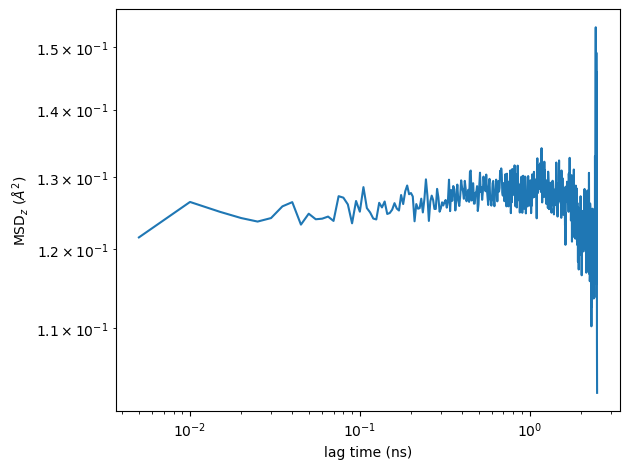

In [79]:
mask = (lag_ns > 0) & (msd_z > 0)

plt.figure()
plt.loglog(lag_ns[mask], msd_z[mask])
plt.xlabel("lag time (ns)")
plt.ylabel(r"MSD$_z$ ($\AA^2$)")
plt.tight_layout()
plt.show()